# Colab Toy Model Test Workflow

In [76]:
import math
import os
from random import shuffle
import glob
import random 
import pandas as pd
import numpy as np

import cv2
import keras

from PIL import Image
from matplotlib import pyplot as plt
from skimage.io import imshow
from PIL import Image

from tensorflow.keras.utils import normalize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical


import segmentation_models as sm

from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split

# Segmentation Models
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from tensorflow.keras.metrics import MeanIoU

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K


## Data loading 

In [29]:
# image and label directories paths
image_path = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/images/edr"
label_path = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/labels/train"

In [21]:
"""
# Import train and mask dataset

train_path = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/images/edr/*.JPG"
def importing_data(path):
    sample = []
    for filename in glob.glob(path):
        img = Image.open(filename,'r')
        img = img.resize((256,256))
        img = np.array(img)
        sample.append(img)  
    return sample

data_train   = importing_data(train_path)
data_train = np.asarray(data_train)


mask_path = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/labels/train/*.png"
def importing_data(path):
    sample = []
    for filename in glob.glob(path):
        img = Image.open(filename,'r')
        img = img.resize((256,256))
        img = np.array(img)
        sample.append(img)  
    return sample

data_mask   = importing_data(mask_path)
data_mask  = np.asarray(data_mask)
"""

In [39]:
"""
# Import img and lab dataset

img_path = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/images/edr/*.JPG"
lab_path = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/labels/train/*.png"
def importing_data(lab_path):
    sample_img = []
    sample_lab = []
    for lab_name in glob.glob(lab_path):
        img_name = lab_name[:-4] + ".JPG"
        if img_name in glob.glob(img_path):
            img = Image.open(img_name,'r')
            img = img.resize((256,256))
            img = np.array(img)
            sample_img.append(img)
            
            lab = Image.open(lab_name,'r')
            lab = lab.resize((256,256))
            lab = np.array(lab)
            sample_lab.append(lab)  
    return sample_img,sample_lab
"""

In [40]:
"""
img_lab_dataset = importing_data(lab_path)
img_lab_dataset = np.asarray(img_lab_dataset)
"""

In [52]:
#img_lab_dataset.size

0

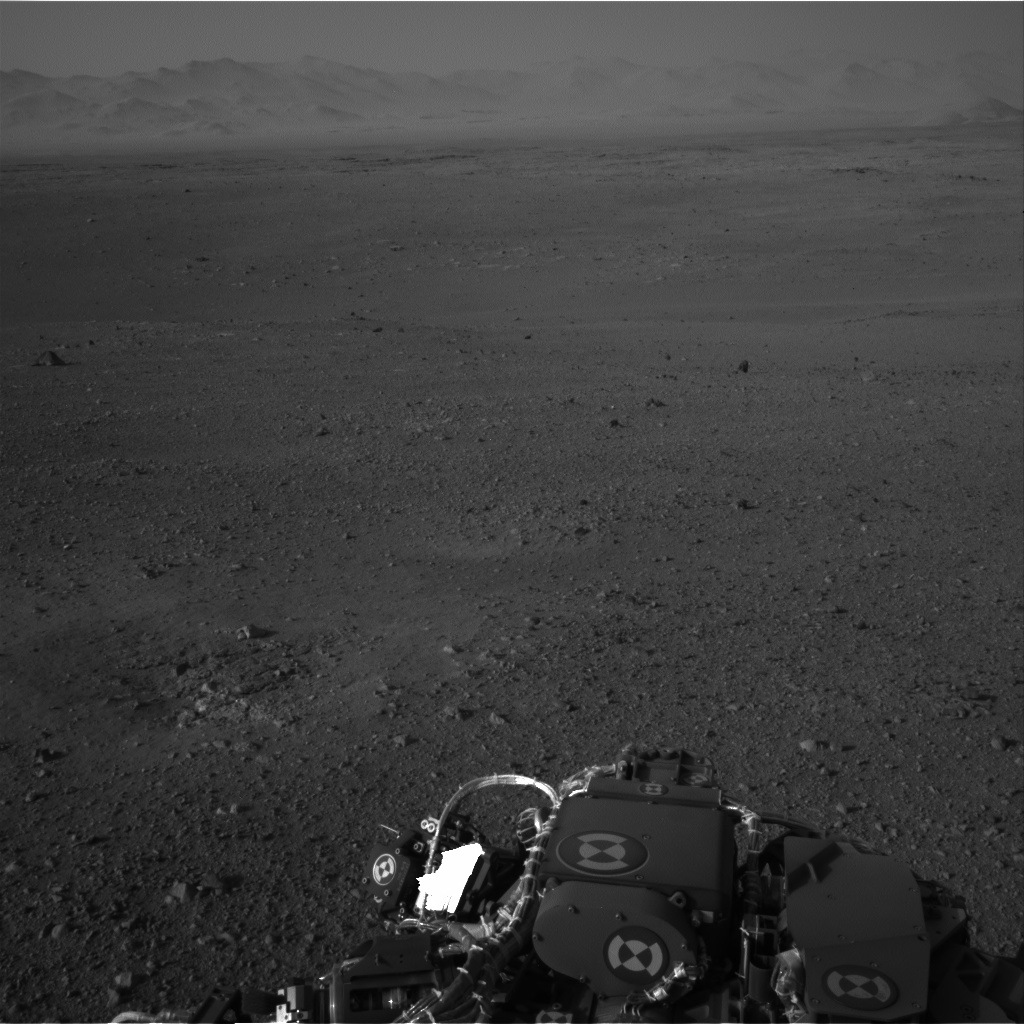

In [20]:
#Image.open("/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/images/edr/NLA_397681372EDR_F0020000AUT_04096M1.JPG")


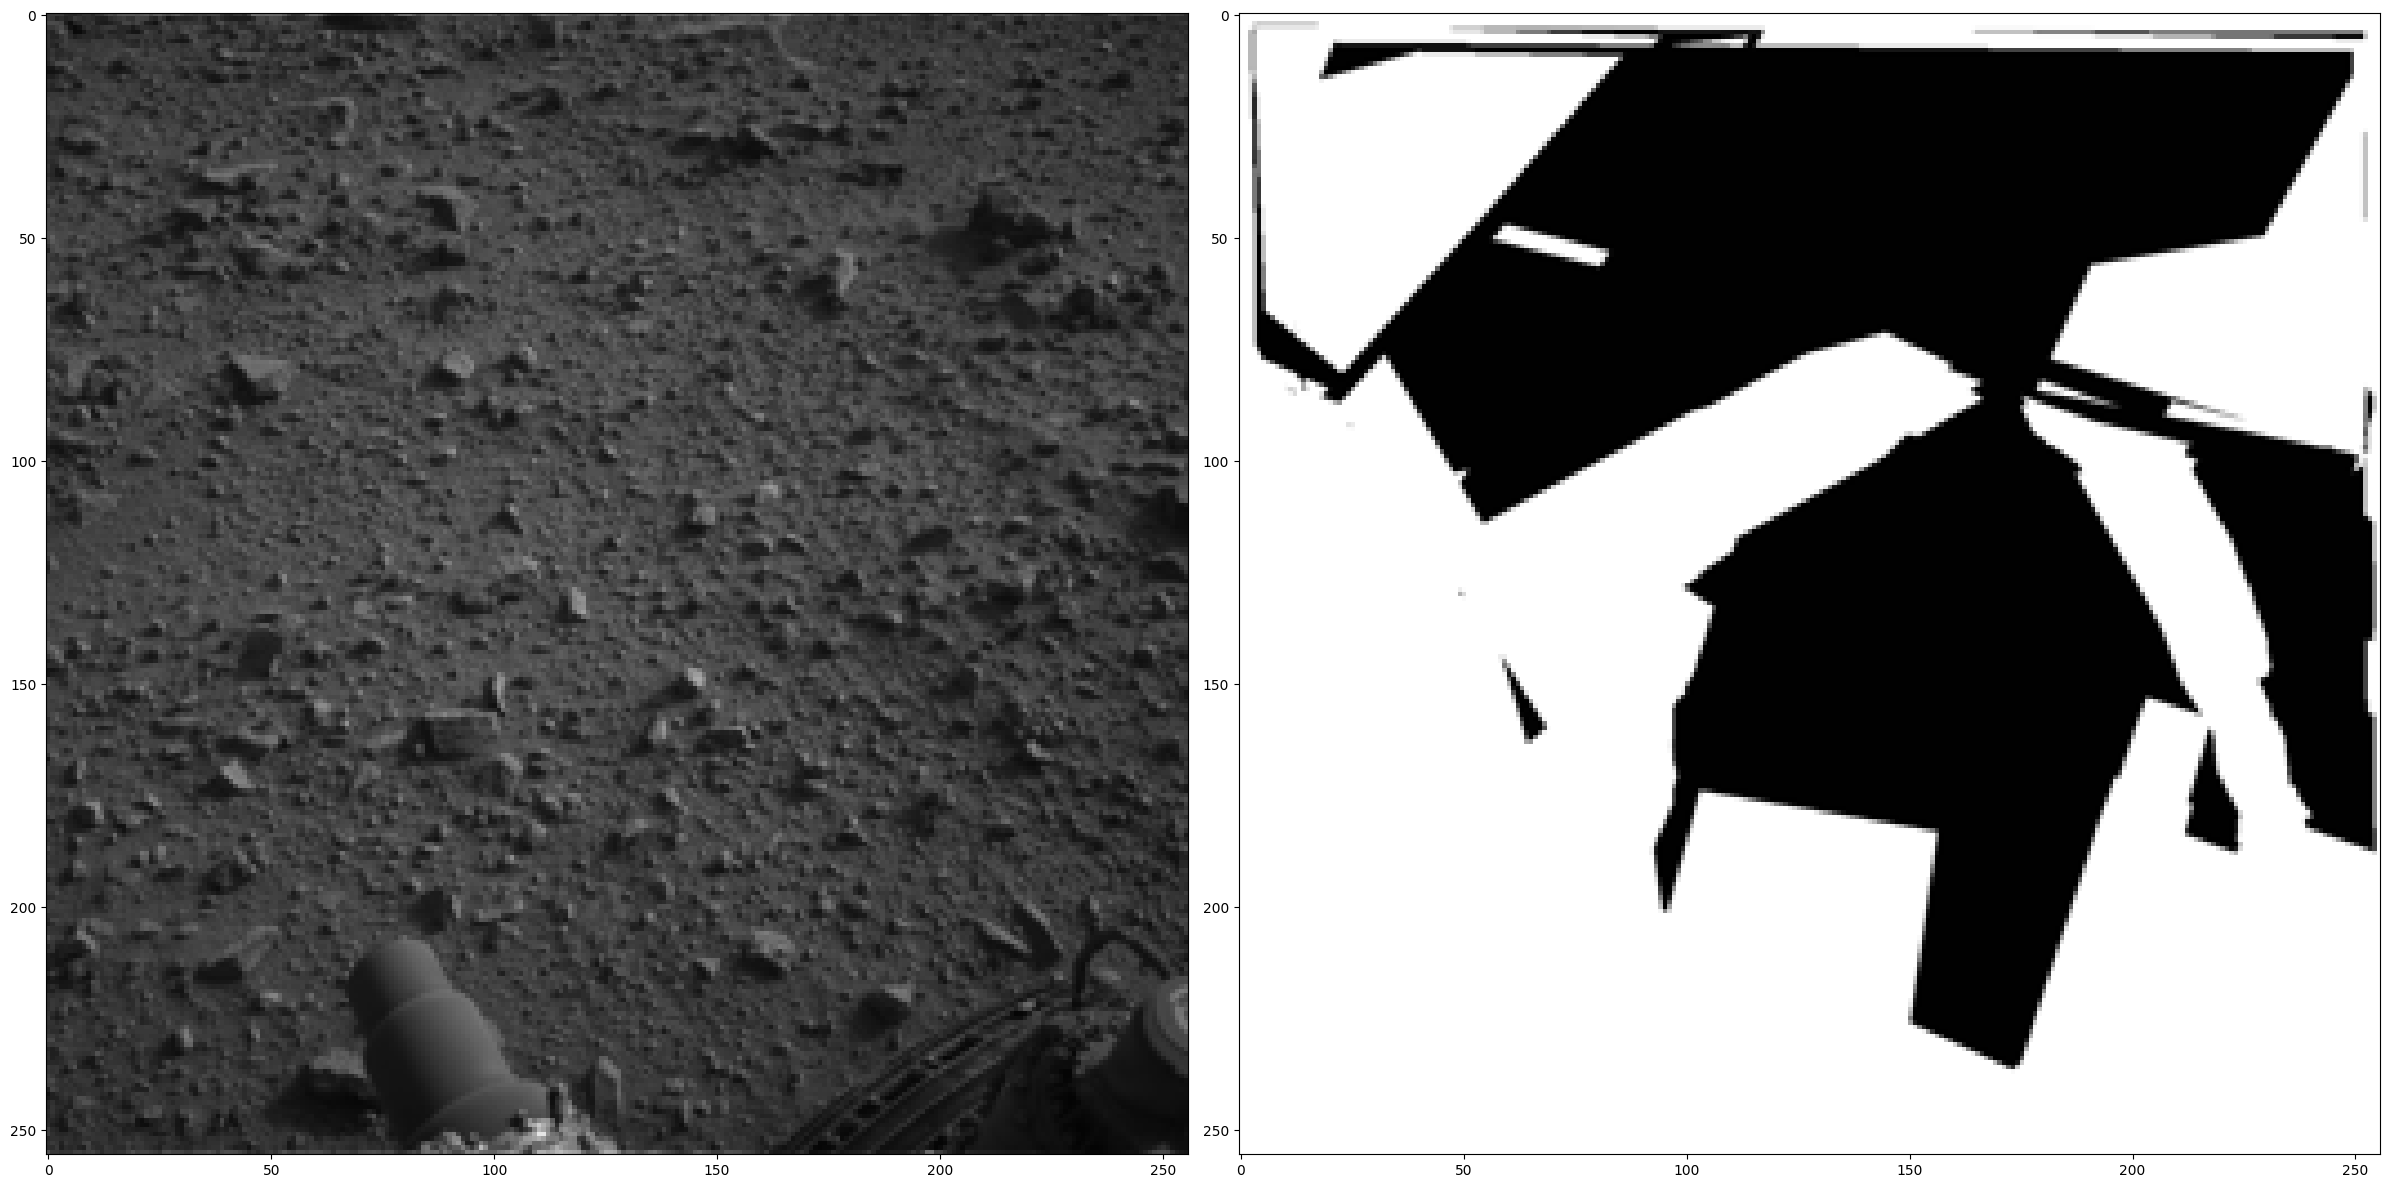

In [27]:
"""
# Random visualization

x = random.randint(0, len(data_train))
plt.figure(figsize=(24,18))
plt.subplot(1,2,1)
imshow(data_train[x])
plt.subplot(1,2,2)
imshow(data_mask[x])
plt.show()
"""

### Random visualization of overlapped image and label

In [66]:
edr_files = os.listdir(image_path)
trlab_files = os.listdir(label_path)

X = []
y = []
c = 0

# preparing X and y
for lab_name in trlab_files:
    img_name = lab_name[:-4] + ".JPG"
    
    if img_name in edr_files:
        
        img_path = os.path.join(image_path, img_name)
        img_arr = cv2.imread(img_path)
        img_arr = cv2.resize(img_arr, dsize = (256, 256))
        
        lab_path = os.path.join(label_path, lab_name)
        lab_arr = cv2.imread(lab_path, 0)
        lab_arr = cv2.resize(lab_arr, (256, 256), interpolation = cv2.INTER_NEAREST)
        
        X.append(img_arr)
        y.append(lab_arr)
        
    c += 1
    if c >= 1000:
        break
        
X = np.asarray(X, dtype = np.float32) / 255.0
y = np.array(y, dtype = np.uint8)

# 0 - soil
# 1 - bedrock
# 2 - sand
# 3 - big rock
# 255 -> 4 - NULL (no label)


# keeping integer values in labels will help us in segmentation task (UNet)
y[y==255] = 4

print(X.shape, y.shape)

(498, 256, 256, 3) (498, 256, 256)


[1 2 4]


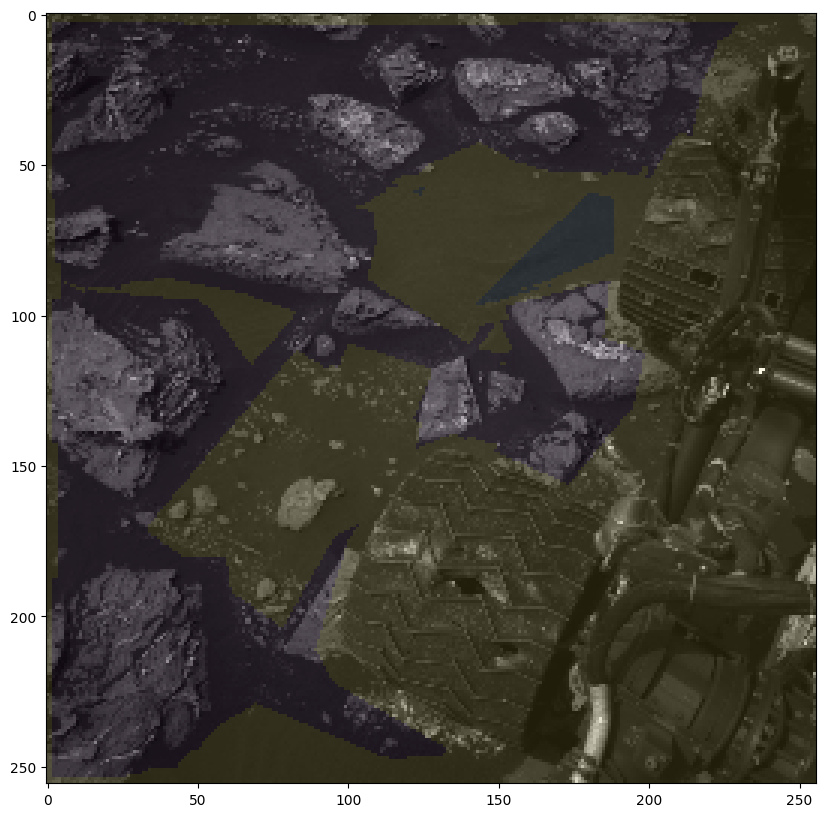

In [37]:
n = random.randint(0, len(X))
print(np.unique(y[n]))

plt.figure(figsize = (10, 10))

plt.imshow(X[n])
plt.imshow(y[n], alpha = 0.1)

plt.show()

In [34]:
# The 3 channels of each image are the same
#print(X[0][:,:,0])

[[0.23529412 0.19607843 0.20784314 ... 0.23529412 0.23137255 0.19607843]
 [0.21568628 0.23529412 0.2784314  ... 0.22745098 0.20392157 0.19215687]
 [0.23921569 0.21568628 0.20784314 ... 0.20784314 0.20784314 0.21176471]
 ...
 [0.16862746 0.20392157 0.16078432 ... 0.04313726 0.04313726 0.0627451 ]
 [0.15686275 0.16470589 0.17254902 ... 0.04313726 0.03921569 0.05098039]
 [0.2784314  0.17254902 0.21176471 ... 0.04313726 0.05490196 0.06666667]]


In [35]:
#print(X[0][:,:,1])

[[0.23529412 0.19607843 0.20784314 ... 0.23529412 0.23137255 0.19607843]
 [0.21568628 0.23529412 0.2784314  ... 0.22745098 0.20392157 0.19215687]
 [0.23921569 0.21568628 0.20784314 ... 0.20784314 0.20784314 0.21176471]
 ...
 [0.16862746 0.20392157 0.16078432 ... 0.04313726 0.04313726 0.0627451 ]
 [0.15686275 0.16470589 0.17254902 ... 0.04313726 0.03921569 0.05098039]
 [0.2784314  0.17254902 0.21176471 ... 0.04313726 0.05490196 0.06666667]]


In [36]:
#print(X[0][:,:,2])

[[0.23529412 0.19607843 0.20784314 ... 0.23529412 0.23137255 0.19607843]
 [0.21568628 0.23529412 0.2784314  ... 0.22745098 0.20392157 0.19215687]
 [0.23921569 0.21568628 0.20784314 ... 0.20784314 0.20784314 0.21176471]
 ...
 [0.16862746 0.20392157 0.16078432 ... 0.04313726 0.04313726 0.0627451 ]
 [0.15686275 0.16470589 0.17254902 ... 0.04313726 0.03921569 0.05098039]
 [0.2784314  0.17254902 0.21176471 ... 0.04313726 0.05490196 0.06666667]]


### Build a customized data generator

In [71]:
# Some inputs
image_size = (256,256)
batch_size = 16
num_classes = 5
dataset_path = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl"
input_shape = (256,256)
images = os.listdir(images)

In [63]:
# image and label directories paths
image_path = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/images/edr"
label_path = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/labels/train"
img_files = os.listdir(image_path)
lab_files = os.listdir(label_path)

In [64]:
img_files[0]

'NLB_547175509EDR_F0623350NCAM00268M1.JPG'

In [65]:
lab_files[1]

'NLB_614730632EDR_F0761072NCAM00343M1.png'

In [74]:
# Define a customized data generator
class UnetDataGenerator(keras.utils.Sequence):
    def __init__(self, image_files, label_files, input_shape, batch_size, num_classes, dataset_path):
        self.image_files          = image_files
        self.label_files          = label_files
        self.input_shape        = input_shape
        self.batch_size         = batch_size
        self.num_classes        = num_classes
        self.dataset_path       = dataset_path

    def __len__(self):
        return math.ceil(len(self.images) / float(self.batch_size))

    def __getitem__(self, index):
        input_images  = []
        output_targets = []
        for i in range(index * self.batch_size, (index + 1) * self.batch_size):  
            i           = i % self.length
            name        = self.img_files[i]
            #-------------------------------#
            #   Get images and labels from directories
            #-------------------------------#
            jpg         = Image.open(os.path.join(os.path.join(self.dataset_path, "images/edr"), name))
            png         = Image.open(os.path.join(os.path.join(self.dataset_path, "labels/train"), name))
            #-------------------------------#
            #   Transform images and labels to numpy array, set the label background to 4
            #-------------------------------#
            #jpg, png    = self.get_random_data(jpg, png, self.input_shape, random = self.train)
            jpg         = np.array(jpg, np.float32)/255
            png         = np.array(png, np.uint8)
            png[png == 255] = 4
            
            #-------------------------------------------------------#
            #   One hot encode the labels
            #   Then reshape the labels to the size of the input images
            #-------------------------------------------------------#
            seg_labels  = np.eye(self.num_classes)[png.reshape([-1])]
            seg_labels  = seg_labels.reshape((int(self.input_shape[0]), int(self.input_shape[1]), self.num_classes))

            input_images.append(jpg)
            output_targets.append(seg_labels)

        input_images  = np.array(input_images)
        output_targets = np.array(output_targets)
        return input_images, output_targets


### Base Model building

In [77]:
n_classes=5 
height=256 
width=256 
channels=3
inputs = Input((height, width, channels))

#Down Sampling
conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
conv_1 = Dropout(0.1)(conv_1)  
conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_1)
    
conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_1)
conv_2 = Dropout(0.1)(conv_2)  
conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_2)
pool_2 = MaxPooling2D((2, 2))(conv_2)
     
conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_2)
conv_3 = Dropout(0.1)(conv_3)
conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_3)
pool_3 = MaxPooling2D((2, 2))(conv_3)
     
conv_4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_3)
conv_4 = Dropout(0.1)(conv_4)
conv_4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_4)
pool_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)
     
conv_5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_4)
conv_5 = Dropout(0.2)(conv_5)
conv_5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_5)

#Up Sampling
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv_5)
u6 = concatenate([u6, conv_4])
conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
conv_6 = Dropout(0.2)(conv_6)
conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_6)
     
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv_6)
u7 = concatenate([u7, conv_3])
conv_7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
conv_7 = Dropout(0.1)(conv_7)
conv_7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_7)
     
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv_7)
u8 = concatenate([u8, conv_2])
conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
conv_8 = Dropout(0.2)(conv_8)  
conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_8)
     
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv_8)
u9 = concatenate([u9, conv_1], axis=3)
conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
conv_9 = Dropout(0.1)(conv_9)
conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_9)
     
outputs = Conv2D(n_classes, (1, 1), activation='softmax')(conv_9)
    
model = Model(inputs=[inputs], outputs=[outputs])
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

In [78]:
model.compile(optimizer='adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score]) 

### Base Model Training

In [79]:
# Split train and validation datasets
X_train, X_test, y_train, y_test = train_test_split(input_images, output_targets, test_size = 0.2, random_state = 42)

NameError: name 'input_images' is not defined

In [ ]:
"""
# Some inputs
image_size = (256,256)
batch_size = 16
num_classes = 5
dataset_path = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl"
input_shape = (256,256)
images = os.listdir(images)
# image and label directories paths
image_path = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/images/edr"
label_path = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/labels/train"
img_files = os.listdir(image_path)
lab_files = os.listdir(label_path)
"""

In [ ]:
# Train dataset generator and validation dataset generator
traingen = UnetDataGenerator(X_train,
                         y_train,
                         input_shape,                        
                         batch_size,
                         num_classes,
                         dataset_path)

valgen = UnetDataGenerator(X_test,
                         y_test,
                         input_shape,                        
                         batch_size,
                         num_classes,
                         dataset_path)


In [ ]:
%%time
es = callbacks.EarlyStopping(patience=2,restore_best_weights=True)
#modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format('First_model'), monitor="val_loss", verbose=0, save_best_only=False)


history = model.fit(traingen,
          validation_data=valgen,
          epochs=100,
          callbacks=[es],
          verbose=1)  